In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

In [2]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_dataset(data_rootdir, dirname, group):
    '''
    该函数实现将训练数据或测试数据文件列表堆叠为三维数组
    '''
    filename_list = []
    filepath_list = []
    X = []
    
    # os.walk() 方法是一个简单易用的文件、目录遍历器，可以高效的处理文件、目录。
    for rootdir, dirnames, filenames in os.walk(data_rootdir + dirname):
        for filename in filenames:
            filename_list.append(filename)
            filepath_list.append(os.path.join(rootdir, filename))
        #print(filename_list)
        #print(filepath_list)
    
    # 遍历根目录下的文件，并读取为DataFrame格式；
    for filepath in filepath_list:
        X.append(load_file(filepath))
    
    X = np.dstack(X) # dstack沿第三个维度叠加，两个二维数组叠加后，前两个维度尺寸不变，第三个维度增加；
    y = load_file(data_rootdir+'/y_'+group+'.txt')
    print('{}_X.shape:{},{}_y.shape:{}\n'.format(group,X.shape,group,y.shape))
    return X, y

In [3]:
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    return accuracy

In [17]:
def run_experiment(trainX, trainy, testX, testy, repeats=10):
    # one-hot编码
    # 这个之前的文章中提到了，因为原数据集标签从1开始，而one-hot编码从0开始，所以要先减去1
    trainy = to_categorical(trainy-1)
    testy = to_categorical(testy-1)
    
    scores = []
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        print(scores)
    
    mean_scores, std_scores = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (mean_scores, std_scores))

In [19]:
train_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/'
test_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/'
dirname = '/Inertial Signals/'
trainX, trainy = load_dataset(train_dir, dirname, 'train')
testX, testy = load_dataset(test_dir, dirname, 'test')
run_experiment(trainX, trainy, testX, testy, repeats=1)

train_X.shape:(7352, 128, 9),train_y.shape:(7352, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2947, 1)

>#1: 91.788
[91.78826212882996]
Accuracy: 91.788% (+/-0.000)


# 调参

longX.shape: (470528, 9)


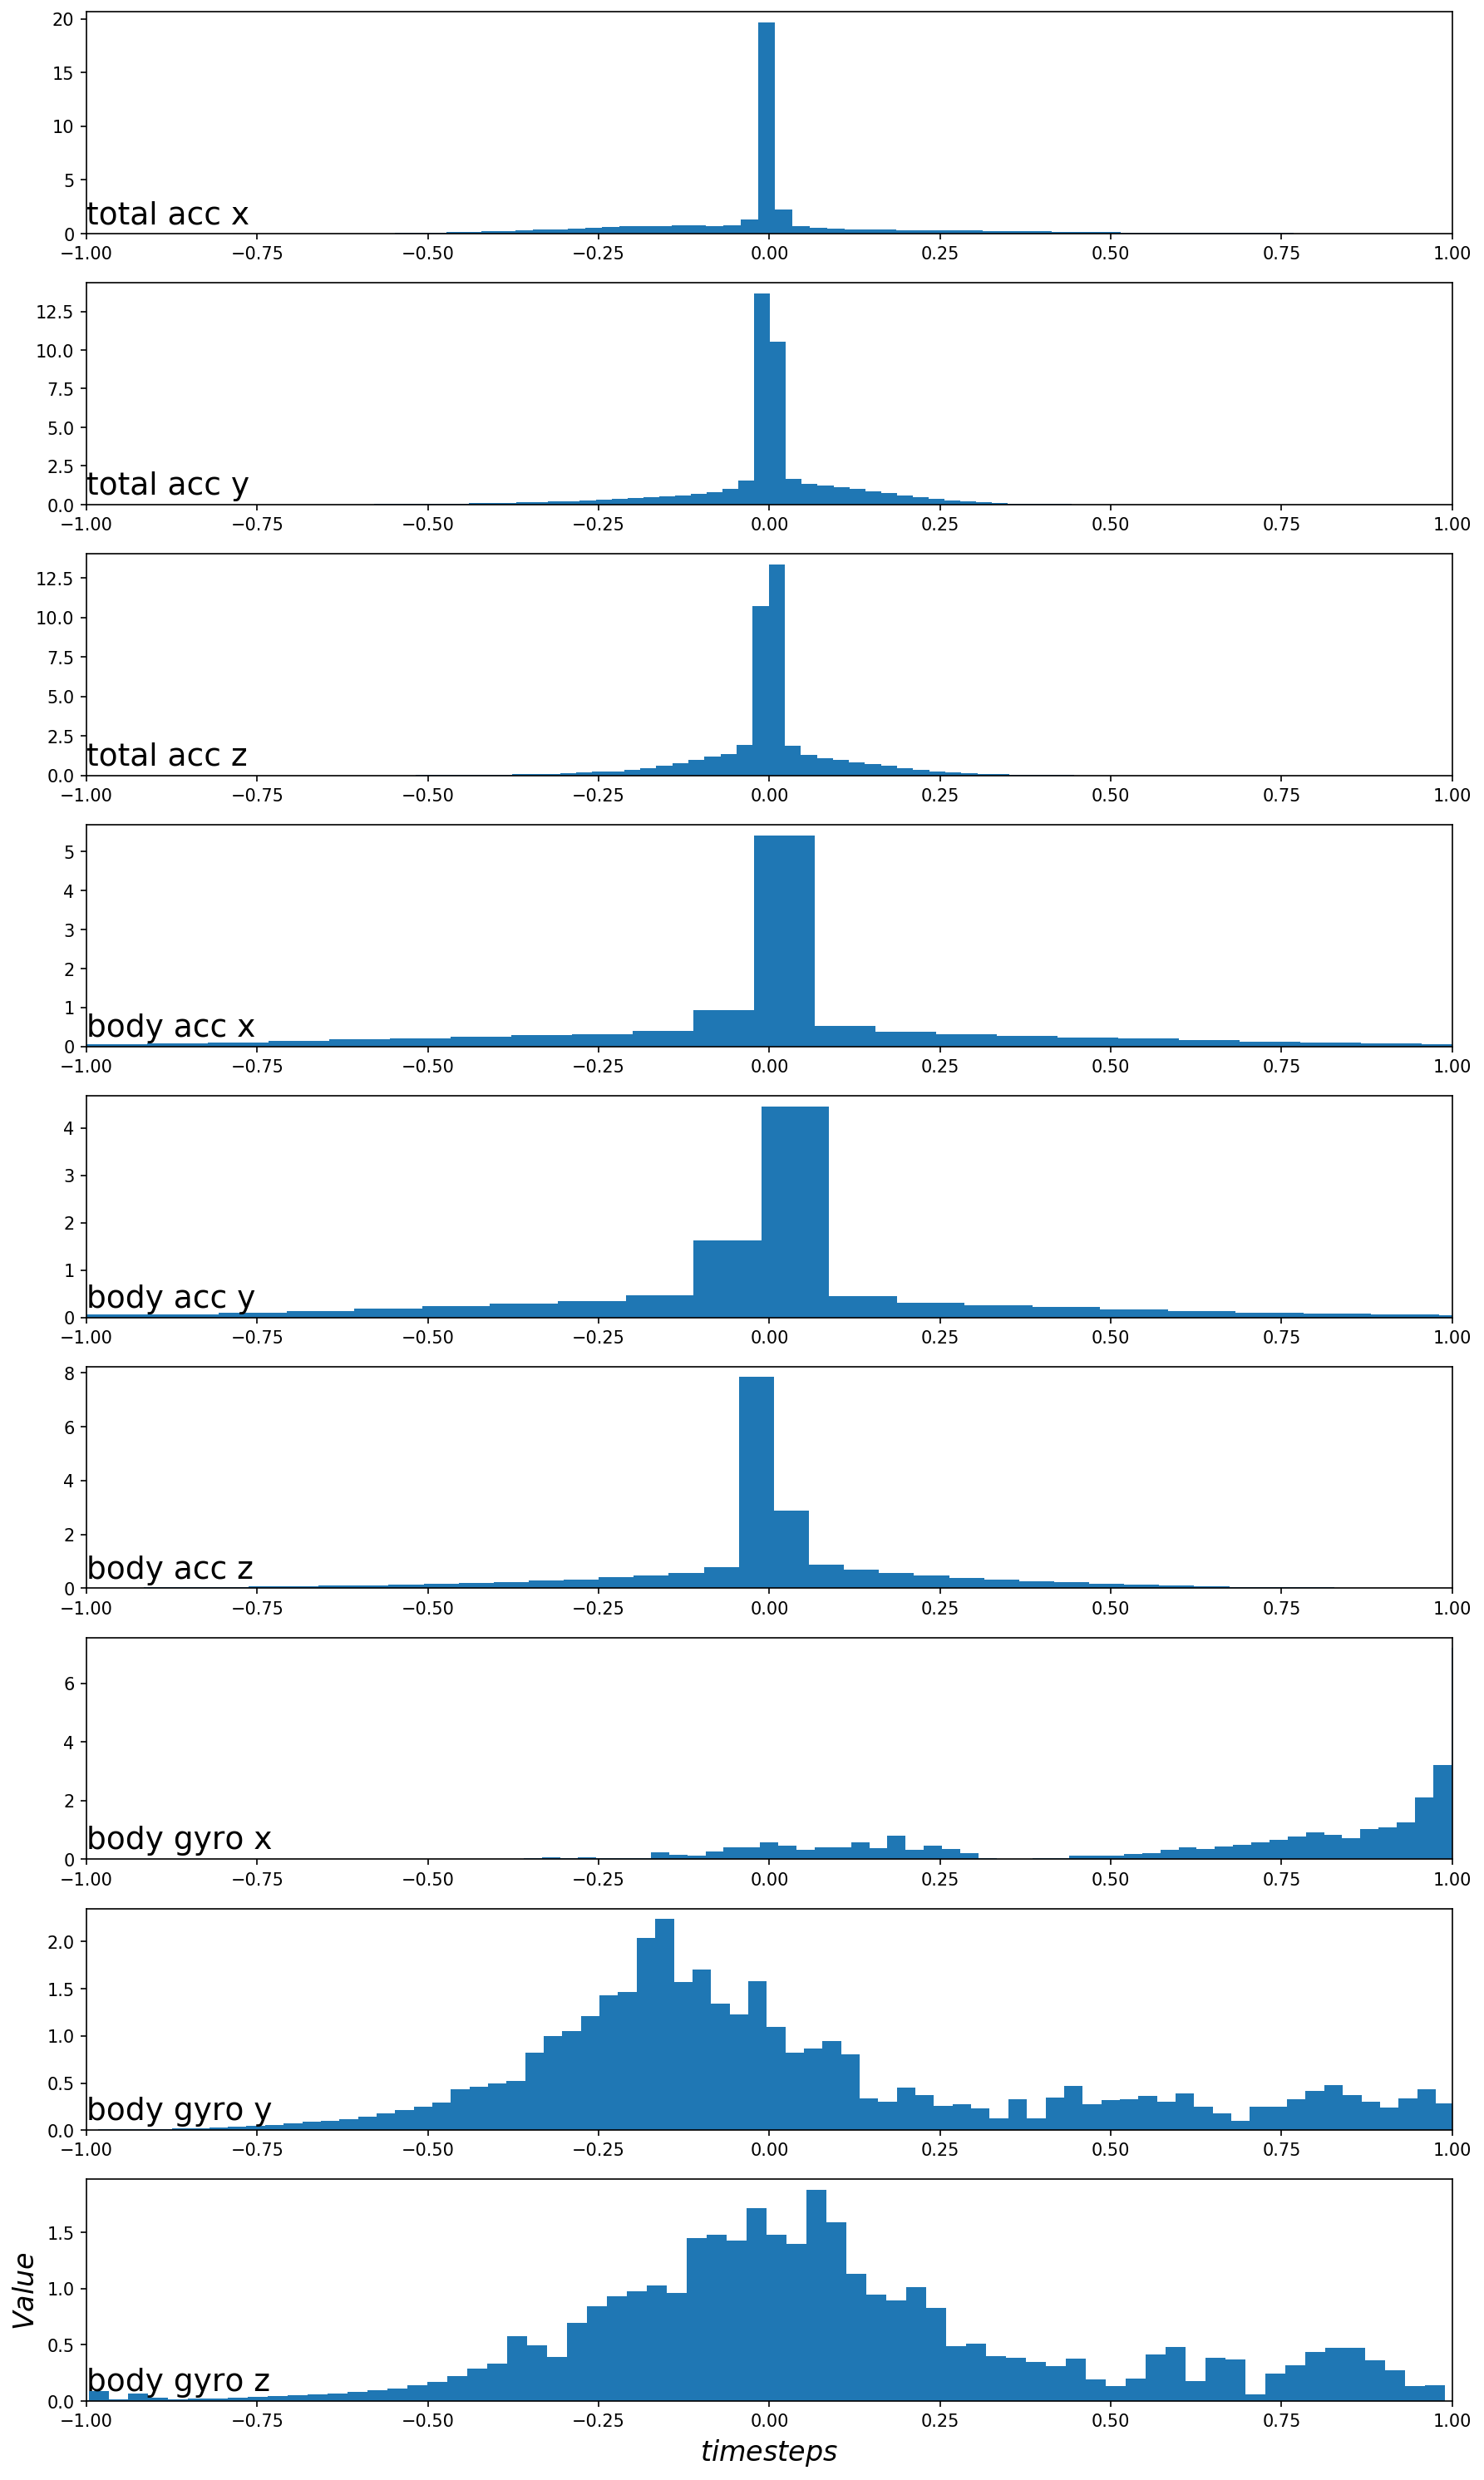

In [24]:
def plot_variable_histograms(data):
    '''
    该函数实现绘制训练集直方图；
    '''
    # 去重
    cut = int(data.shape[1] / 2)
    longX = data[:, -cut:, :]
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    print('longX.shape:', longX.shape)
    # 绘图
    plt.figure(figsize=(12,20), dpi=150)    
    
    name_list = ['total acc ', 'body acc ', 'body gyro ']
    axis_list = ['x', 'y', 'z']
    features_list = []
    for name in name_list:
        for axis in axis_list:
            features_list.append(name+axis)

    for i in range(len(features_list)):
        ax = plt.subplot(longX.shape[1], 1, i+1)
        ax.set_xlim(-1, 1)
        ax.hist(longX[:, i], bins=100, density=True, histtype='bar', stacked=True)
        plt.title(features_list[i], y=0, loc='left', size=18)
    
    plt.ylabel(r'$Value$', size=16)
    plt.xlabel(r'$timesteps$', size=16)
    plt.tight_layout()         
    plt.show()
    
plot_variable_histograms(trainX)

# 数据标准化的影响

train_X.shape:(7352, 128, 9),train_y.shape:(7352, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2947, 1)

>p=False #1: 91.110
>p=False #2: 93.146
>p=False #3: 90.058
>p=False #4: 91.924
>p=False #5: 91.958
>p=False #6: 89.786
>p=False #7: 89.990
>p=False #8: 91.177
>p=False #9: 90.159
>p=False #10: 91.754
>p=True #1: 91.415
>p=True #2: 92.535
>p=True #3: 91.788
>p=True #4: 90.668
>p=True #5: 91.008
>p=True #6: 88.768
>p=True #7: 92.297
>p=True #8: 91.347
>p=True #9: 91.449
>p=True #10: 91.619
[[91.10960364341736, 93.14557313919067, 90.05768299102783, 91.923987865448, 91.95792078971863, 89.78622555732727, 89.98982310295105, 91.17746949195862, 90.15948176383972, 91.75432920455933], [91.41499996185303, 92.53478050231934, 91.78826212882996, 90.66847562789917, 91.00780487060547, 88.76823782920837, 92.29725003242493, 91.34713411331177, 91.44893288612366, 91.6185975074768]] [False, True]
Param=False: 91.106% (+/-1.047)
Param=True: 91.289% (+/-0.989)


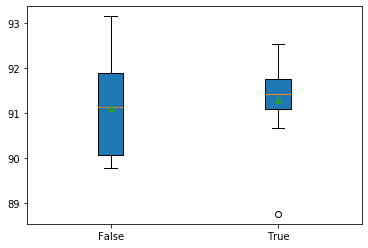

In [29]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_dataset(data_rootdir, dirname, group):
    '''
    该函数实现将训练数据或测试数据文件列表堆叠为三维数组
    '''
    filename_list = []
    filepath_list = []
    X = []
    
    # os.walk() 方法是一个简单易用的文件、目录遍历器，可以高效的处理文件、目录。
    for rootdir, dirnames, filenames in os.walk(data_rootdir + dirname):
        for filename in filenames:
            filename_list.append(filename)
            filepath_list.append(os.path.join(rootdir, filename))
        #print(filename_list)
        #print(filepath_list)
    
    # 遍历根目录下的文件，并读取为DataFrame格式；
    for filepath in filepath_list:
        X.append(load_file(filepath))
    
    X = np.dstack(X) # dstack沿第三个维度叠加，两个二维数组叠加后，前两个维度尺寸不变，第三个维度增加；
    y = load_file(data_rootdir+'/y_'+group+'.txt')
    print('{}_X.shape:{},{}_y.shape:{}\n'.format(group,X.shape,group,y.shape))
    return X, y

def scale_data(trainX, testX, standardize):
    # 去重
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:, -cut:, :]
    # 将窗口数据展平
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    # 展平训练集和测试集数据
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    # 标准化
    if standardize:
        s = StandardScaler()
        s.fit(longX)
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
    
    # 重塑形状，以方便训练
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX


def evaluate_model(trainX, trainy, testX, testy, param):
    verbose, epochs, batch_size = 0, 10, 32
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    trainX, testX = scale_data(trainX, testX, param)
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy


def summarize_results(scores, params):
    print(scores, params)
    # 总结均值和标准差
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # 绘制分数的箱型图
    plt.boxplot(scores, vert=True,  patch_artist=True, showmeans=True, labels=params)
    plt.savefig('exp_cnn_standardize.png', dpi=150)
    plt.show()

def run_experiment(trainX, trainy, testX, testy, params, repeats=10):
    # one-hot编码
    # 这个之前的文章中提到了，因为原数据集标签从1开始，而one-hot编码从0开始，所以要先减去1
    trainy = to_categorical(trainy-1)
    testy = to_categorical(testy-1)
    
    all_scores = list()
    for p in params:

        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%s #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)

    summarize_results(all_scores, params)

train_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/'
test_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/'
dirname = '/Inertial Signals/'
trainX, trainy = load_dataset(train_dir, dirname, 'train')
testX, testy = load_dataset(test_dir, dirname, 'test')

n_params = [False, True]
run_experiment(trainX, trainy, testX, testy, n_params, repeats=10)

# filters 数量的影响

train_X.shape:(7352, 128, 9),train_y.shape:(7352, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2947, 1)

>p=8 #1: 90.465
>p=8 #2: 87.954
>p=16 #1: 89.718
>p=16 #2: 89.684
>p=32 #1: 89.650
>p=32 #2: 90.770
>p=64 #1: 91.076
>p=64 #2: 90.024
>p=128 #1: 90.872
>p=128 #2: 89.006
>p=256 #1: 81.337
>p=256 #2: 89.515
[[90.46487808227539, 87.95385360717773], [89.71835970878601, 89.68442678451538], [89.65049386024475, 90.77027440071106], [91.07567071914673, 90.0237500667572], [90.87207317352295, 89.00576829910278], [81.33695125579834, 89.51476216316223]] [8, 16, 32, 64, 128, 256]
Param=8: 89.209% (+/-1.256)
Param=16: 89.701% (+/-0.017)
Param=32: 90.210% (+/-0.560)
Param=64: 90.550% (+/-0.526)
Param=128: 89.939% (+/-0.933)
Param=256: 85.426% (+/-4.089)


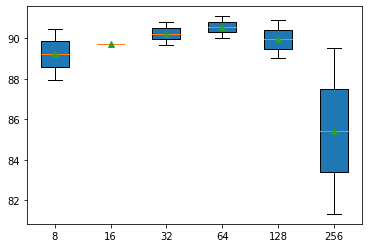

In [30]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_dataset(data_rootdir, dirname, group):
    '''
    该函数实现将训练数据或测试数据文件列表堆叠为三维数组
    '''
    filename_list = []
    filepath_list = []
    X = []
    
    # os.walk() 方法是一个简单易用的文件、目录遍历器，可以高效的处理文件、目录。
    for rootdir, dirnames, filenames in os.walk(data_rootdir + dirname):
        for filename in filenames:
            filename_list.append(filename)
            filepath_list.append(os.path.join(rootdir, filename))
        #print(filename_list)
        #print(filepath_list)
    
    # 遍历根目录下的文件，并读取为DataFrame格式；
    for filepath in filepath_list:
        X.append(load_file(filepath))
    
    X = np.dstack(X) # dstack沿第三个维度叠加，两个二维数组叠加后，前两个维度尺寸不变，第三个维度增加；
    y = load_file(data_rootdir+'/y_'+group+'.txt')
    print('{}_X.shape:{},{}_y.shape:{}\n'.format(group,X.shape,group,y.shape))
    return X, y


def evaluate_model(trainX, trainy, testX, testy, n_kernel):
    verbose, epochs, batch_size = 0, 10, 32
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', 
                     input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy


def summarize_results(scores, params):
    print(scores, params)
    # 总结均值和标准差
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # 绘制分数的箱型图
    plt.boxplot(scores, vert=True,  patch_artist=True, showmeans=True, labels=params)
    plt.savefig('exp_cnn_filters.png', dpi=150)
    plt.show()

def run_experiment(trainX, trainy, testX, testy, params, repeats=10):
    # one-hot编码
    # 这个之前的文章中提到了，因为原数据集标签从1开始，而one-hot编码从0开始，所以要先减去1
    trainy = to_categorical(trainy-1)
    testy = to_categorical(testy-1)
    
    all_scores = list()
    for p in params:

        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, p)
            score = score * 100.0
            print('>p=%s #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)

    summarize_results(all_scores, params)

train_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/'
test_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/'
dirname = '/Inertial Signals/'
trainX, trainy = load_dataset(train_dir, dirname, 'train')
testX, testy = load_dataset(test_dir, dirname, 'test')

n_params = [8, 16, 32, 64, 128, 256]
run_experiment(trainX, trainy, testX, testy, n_params, repeats=2)

train_X.shape:(7352, 128, 9),train_y.shape:(7352, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2947, 1)

>p=2 #1: 88.700
>p=2 #2: 91.211
>p=3 #1: 91.076
>p=3 #2: 89.549
>p=5 #1: 90.736
>p=5 #2: 90.974
>p=7 #1: 88.836
>p=7 #2: 92.874
>p=11 #1: 92.603
>p=11 #2: 84.628
[[88.70037198066711, 91.21140241622925], [91.07567071914673, 89.54869508743286], [90.73634147644043, 90.97387194633484], [88.83610367774963, 92.87410974502563], [92.6026463508606, 84.62843298912048]] [2, 3, 5, 7, 11]
Param=2: 89.956% (+/-1.256)
Param=3: 90.312% (+/-0.763)
Param=5: 90.855% (+/-0.119)
Param=7: 90.855% (+/-2.019)
Param=11: 88.616% (+/-3.987)


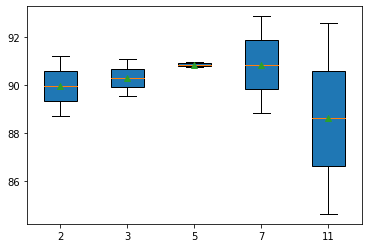

In [34]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_dataset(data_rootdir, dirname, group):
    '''
    该函数实现将训练数据或测试数据文件列表堆叠为三维数组
    '''
    filename_list = []
    filepath_list = []
    X = []
    
    # os.walk() 方法是一个简单易用的文件、目录遍历器，可以高效的处理文件、目录。
    for rootdir, dirnames, filenames in os.walk(data_rootdir + dirname):
        for filename in filenames:
            filename_list.append(filename)
            filepath_list.append(os.path.join(rootdir, filename))
        #print(filename_list)
        #print(filepath_list)
    
    # 遍历根目录下的文件，并读取为DataFrame格式；
    for filepath in filepath_list:
        X.append(load_file(filepath))
    
    X = np.dstack(X) # dstack沿第三个维度叠加，两个二维数组叠加后，前两个维度尺寸不变，第三个维度增加；
    y = load_file(data_rootdir+'/y_'+group+'.txt')
    print('{}_X.shape:{},{}_y.shape:{}\n'.format(group,X.shape,group,y.shape))
    return X, y


def evaluate_model(trainX, trainy, testX, testy, n_filters, n_kernel):
    verbose, epochs, batch_size = 0, 10, 32
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', 
                     input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy


def summarize_results(scores, params):
    print(scores, params)
    # 总结均值和标准差
    for i in range(len(scores)):
        m, s = np.mean(scores[i]), np.std(scores[i])
        print('Param=%s: %.3f%% (+/-%.3f)' % (params[i], m, s))
    # 绘制分数的箱型图
    plt.boxplot(scores, vert=True,  patch_artist=True, showmeans=True, labels=params)
    plt.savefig('exp_cnn_kernels.png', dpi=150)
    plt.show()

def run_experiment(trainX, trainy, testX, testy, n_filters, params, repeats=10):
    # one-hot编码
    # 这个之前的文章中提到了，因为原数据集标签从1开始，而one-hot编码从0开始，所以要先减去1
    trainy = to_categorical(trainy-1)
    testy = to_categorical(testy-1)
    
    all_scores = list()
    for p in params:

        scores = list()
        for r in range(repeats):
            score = evaluate_model(trainX, trainy, testX, testy, n_filters, p)
            score = score * 100.0
            print('>p=%s #%d: %.3f' % (p, r+1, score))
            scores.append(score)
        all_scores.append(scores)

    summarize_results(all_scores, params)

train_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/'
test_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/'
dirname = '/Inertial Signals/'
trainX, trainy = load_dataset(train_dir, dirname, 'train')
testX, testy = load_dataset(test_dir, dirname, 'test')

#n_filters = [8, 16, 32, 64, 128, 256]
n_filters = 64
n_kernels = [2, 3, 5, 7, 11]
run_experiment(trainX, trainy, testX, testy, n_filters, n_kernels, repeats=2)

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.utils import to_categorical, plot_model

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

def load_dataset(data_rootdir, dirname, group):
    '''
    该函数实现将训练数据或测试数据文件列表堆叠为三维数组
    '''
    filename_list = []
    filepath_list = []
    X = []
    
    # os.walk() 方法是一个简单易用的文件、目录遍历器，可以高效的处理文件、目录。
    for rootdir, dirnames, filenames in os.walk(data_rootdir + dirname):
        for filename in filenames:
            filename_list.append(filename)
            filepath_list.append(os.path.join(rootdir, filename))
        #print(filename_list)
        #print(filepath_list)
    
    # 遍历根目录下的文件，并读取为DataFrame格式；
    for filepath in filepath_list:
        X.append(load_file(filepath))
    
    X = np.dstack(X) # dstack沿第三个维度叠加，两个二维数组叠加后，前两个维度尺寸不变，第三个维度增加；
    y = load_file(data_rootdir+'/y_'+group+'.txt')
    print('{}_X.shape:{},{}_y.shape:{}\n'.format(group,X.shape,group,y.shape))
    return X, y

def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    # head 1
    inputs1 = Input(shape=(n_timesteps,n_features))
    conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
    drop1 = Dropout(0.5)(conv1)
    pool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(pool1)
    
    # head 2
    inputs2 = Input(shape=(n_timesteps,n_features))
    conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
    drop2 = Dropout(0.5)(conv2)
    pool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(pool2)
    
    # head 3
    inputs3 = Input(shape=(n_timesteps,n_features))
    conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
    drop3 = Dropout(0.5)(conv3)
    pool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(pool3)
    
    # 合并
    merged = concatenate([flat1, flat2, flat3])
    # 解释
    dense1 = Dense(100, activation='relu')(merged)
    outputs = Dense(n_outputs, activation='softmax')(dense1)
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

    plot_model(model, show_shapes=True, to_file='multichannel.png', dpi=200)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)

    _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
    return accuracy

def run_experiment(trainX, trainy, testX, testy, repeats=10):
    # one-hot编码
    # 这个之前的文章中提到了，因为原数据集标签从1开始，而one-hot编码从0开始，所以要先减去1
    trainy = to_categorical(trainy-1)
    testy = to_categorical(testy-1)
    
    scores = []
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        print(scores)
    
    mean_scores, std_scores = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (mean_scores, std_scores))
    
train_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/train/'
test_dir = 'D:/GraduationCode/01 Datasets/UCI HAR Dataset/test/'
dirname = '/Inertial Signals/'
trainX, trainy = load_dataset(train_dir, dirname, 'train')
testX, testy = load_dataset(test_dir, dirname, 'test')
run_experiment(trainX, trainy, testX, testy, repeats=5)

train_X.shape:(7352, 128, 9),train_y.shape:(7352, 1)

test_X.shape:(2947, 128, 9),test_y.shape:(2947, 1)

>#1: 91.822
[91.82218909263611]
>#2: 92.501
[91.82218909263611, 92.5008475780487]
>#3: 91.686
[91.82218909263611, 92.5008475780487, 91.68646335601807]
>#4: 85.579
[91.82218909263611, 92.5008475780487, 91.68646335601807, 85.57855486869812]
>#5: 93.044
[91.82218909263611, 92.5008475780487, 91.68646335601807, 85.57855486869812, 93.04377436637878]
Accuracy: 90.926% (+/-2.718)
